# Fisher Transformation, Inverse Fisher and Cyber Cycle - Bearish day

In [12]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 7

In [13]:
# First import useful tools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [14]:
data = pd.read_csv('https://drive.google.com/uc?export=download&id=0B9-kA56h5JCMU2w4d3JmN1hWZW8',
                 index_col=0, parse_dates=True)
time = data.index
price = data.CLOSE

In [15]:
def fisher(df, norm_window=20):
    # Normalize the price serie.
    df_norm = (df - pd.rolling_min(df, norm_window)) / (pd.rolling_max(df, norm_window) - \
                                                        pd.rolling_min(df, norm_window))
    # Center the serie on its midpoint and then doubled so that df_value
    # swings between −1 and +1.
    df_value = 2 * (df_norm - 0.5)
    # Smoothing df_value by applying EMA with alpha 0.5.
    df_value = 0.5 * df_value + 0.5 * df_value.shift()
    # Avoid division by zero and weird behavior.
    df_value[df_value < -0.999] = -0.999
    df_value[df_value > 0.999] = 0.999
    # Estimate the Fisher transform and smoothing again with an EMA with alpha 0.5.
    df_fisher = 0.5 * np.log((1 + df_value) / (1 - df_value))
    return 0.5 * df_fisher + 0.5 * df_fisher.shift()

## Inverse Fisher Transform

In [16]:
def fisher_inverse(df, norm_window=20):
    # Normalize the price serie.
    df_norm = (df - pd.rolling_min(df, norm_window)) / \
              (pd.rolling_max(df, norm_window) - pd.rolling_min(df, norm_window))
    # Center the serie on its midpoint and then doubled so that df_value
    # swings between −1 and +1.
    df_value = 2 * (df_norm - 0.5)
    # Avoid division by zero and weird behavior.
    df_value[df_value < -0.999] = -0.999
    df_value[df_value > 0.999] = 0.999
    df_inverse_fisher = (np.exp(2 * df_value) - 1) / (np.exp(2 * df_value) + 1)
    return df_inverse_fisher

In [17]:
def cyber_cycle(na_series):
    smooth = np.zeros(len(na_series)) 
    cycle = np.zeros(len(na_series))
    trigger = np.zeros(len(na_series))
    
    smooth[:3] = na_series[:3]
    
    for n in range(3, len(na_series)):
        smooth[n] = (na_series[n] + 2 * na_series[n-1] + 2 * na_series[n-2] + \
        na_series[n-3]) / 6
        if n < 10:
            cycle[n] = (na_series[n] - 2 * na_series[n-1] + na_series[n-2]) / 4
        else:
            cycle[n] = a_ * (smooth[n] - 2 * smooth[n-1] + smooth[n-2]) + \
                       2 * b_ * cycle[n-1] - (b_ ** 2) * cycle[n-2]
        trigger[n] = cycle[n-1]
    return list([cycle, trigger])

Let's estimate the Cyber Cycle of the price series and apply Fisher and Inverse Fisher to the Cyber Cyle indicator.

In [18]:
alpha = 0.07
a_ = (1 - 0.5 * alpha) ** 2
b_ = 1 - alpha

ccycle, trigger = cyber_cycle(price)

FCC = fisher(pd.Series(ccycle))
IFCC = fisher_inverse(pd.Series(ccycle))

df = pd.DataFrame(np.transpose(np.vstack((price, ccycle, trigger, FCC, IFCC))),
                  index=data.index,
                  columns=['Price', 'CyberCycle', 'Trigger', 'FisherCyberCycle',
                           'InvFisherCyberCycle'])

#Signaling performance
##Cyber Cycle Oscilator

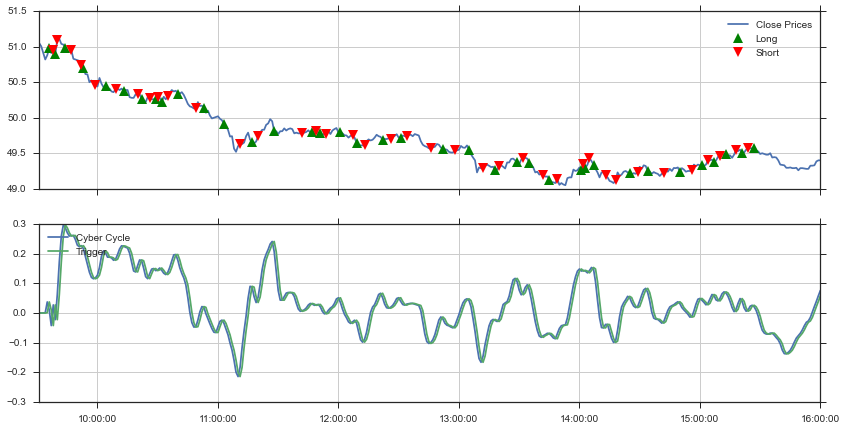

In [19]:
# Plotting
f, ax = plt.subplots(2, sharex=True)

threshold = 0.7
tol = 0.001

long_signal = (df.CyberCycle.shift() > df.Trigger.shift() + tol) & (df.CyberCycle < df.Trigger - tol)
short_signal = (df.CyberCycle.shift() < df.Trigger.shift() - tol) & (df.CyberCycle > df.Trigger + tol)

ax[0].plot(time, data.CLOSE, label='Close Prices')
ax[0].plot(time[long_signal], df.Price[long_signal], linestyle='None', marker='^', 
           color='g', markersize=10, label='Long')
ax[0].plot(time[short_signal], df.Price[short_signal], linestyle='None', marker='v',
           color='r', markersize=10, label='Short')
ax[0].legend(loc='upper right')
ax[0].grid()

ax[1].plot(time, ccycle, label='Cyber Cycle')
ax[1].plot(time, trigger, label='Trigger')
ax[1].legend(loc='upper left')
ax[1].grid()

##Fisher Cyber Cycle

In [20]:
def trigger_idx(pd_series, threshold, tol):
    cond_1 = (pd_series.shift() < threshold) & (pd_series > threshold + tol)
    cond_2 = (pd_series.shift() > threshold) & (pd_series < threshold - tol)

    cond_3 = (pd_series.shift() < -threshold) & (pd_series > -threshold + tol)
    cond_4 = (pd_series.shift() > -threshold) & (pd_series < -threshold - tol)
    return list([cond_1, cond_2, cond_3, cond_4])

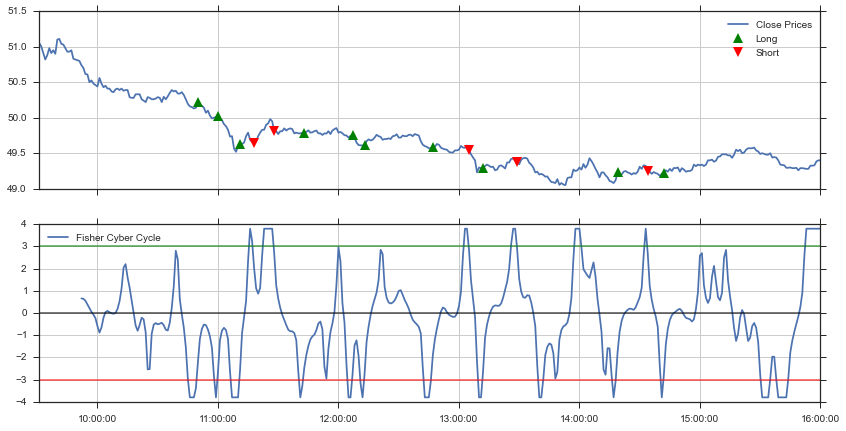

In [21]:
# Plotting
f, ax = plt.subplots(2, sharex=True)

threshold = 3 
signals = trigger_idx(df.FisherCyberCycle, threshold, 0.1)

long_signal = signals[2]
short_signal = signals[1]

ax[0].plot(time, data.CLOSE, label='Close Prices')
ax[0].plot(time[long_signal], df.Price[long_signal], linestyle='None', marker='^', 
           color='g', markersize=10, label='Long')
ax[0].plot(time[short_signal], df.Price[short_signal], linestyle='None', marker='v',
           color='r', markersize=10, label='Short')
ax[0].legend(loc='upper right')
ax[0].grid()

ax[1].plot(time, df.FisherCyberCycle, label='Fisher Cyber Cycle')
ax[1].axhline(y=threshold, color='green', alpha=0.6)
ax[1].axhline(y=-threshold, color='red', alpha=0.6)
ax[1].axhline(y=0, color='black', alpha=0.6)
ax[1].legend(loc='upper left')
ax[1].grid()


##Inverse Fisher Cyber Cycle

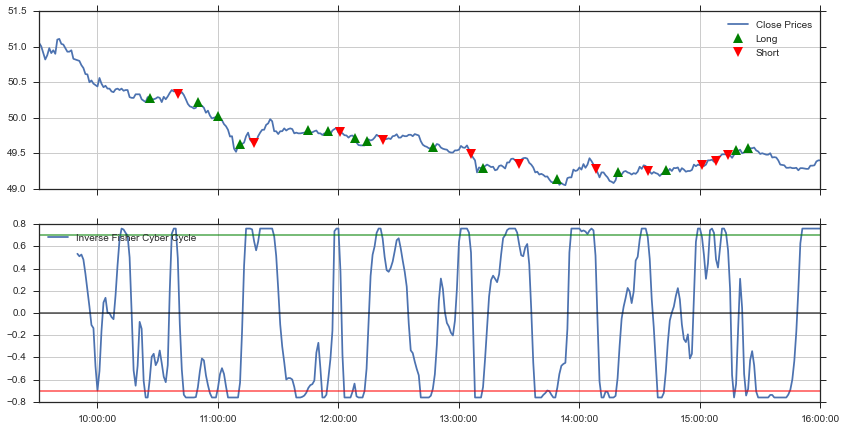

In [22]:
# Plotting
f, ax = plt.subplots(2, sharex=True)

threshold = 0.7 
signals = trigger_idx(df.InvFisherCyberCycle, threshold, 0.01)

long_signal = signals[2]
short_signal = signals[1]

ax[0].plot(time, data.CLOSE, label='Close Prices')
ax[0].plot(time[long_signal], df.Price[long_signal], linestyle='None', marker='^', 
           color='g', markersize=10, label='Long')
ax[0].plot(time[short_signal], df.Price[short_signal], linestyle='None', marker='v',
           color='r', markersize=10, label='Short')
ax[0].legend(loc='upper right')
ax[0].grid()

ax[1].plot(time, df.InvFisherCyberCycle, label='Inverse Fisher Cyber Cycle')
ax[1].axhline(y=threshold, color='green', alpha=0.6)
ax[1].axhline(y=-threshold, color='red', alpha=0.6)
ax[1].axhline(y=0, color='black', alpha=0.6)
ax[1].legend(loc='upper left')
ax[1].grid()